ELEC-E5550 - Statistical Natural Language Processing
# SET 4: POS-tagging

## Released: 31.01.2021
## Deadline: 13.02.2023 23:59 

# Overview

**Part-of-speech tagging** (**POS tagging**) is the process of annotating words in an input sequence with their corresponding part-of-speech labels. Word's **part-of-speech** gives us more information about the word itself and about its neighboring words (nouns are preceded by determiners "a dog" and adjectives "nice dog"). For instance, we can use POS tags as features for the Named Entitity Recognition task: Proper Nouns like names are usually these entities. Moreover, a word's **part-of-speech** provides us with an understanding of how to pronounce this word: cOntent if it is a noun and contEnt if it is an adjective. This helps in such tasks as speech synthesis.

In this assignment we're going to create two systems for assigning POS tags. They are both based on statistics collected from a corpus annotated with POS tags by humans. First, we will be assigning words the most frequent tag it has been seen with. This is a **baseline** we will be trying to beat. Second, we will create a **Hidden Markov Model** **HMM** system and compare its performance to our baseline. The POS tagging algorithm is judged by how **accurate** it is. So we are going to use **accuracy** as the performance metric.

For this assignment we will be using [the GUM corpus](https://corpling.uis.georgetown.edu/gum/) annotated with [Universal Dependencies POS tags](https://universaldependencies.org/u/pos/). We recomend to study the tags, to understand what each of them means.

* `/coursedata/pos-tagging/tags_vocab.txt` - vocabulary of UD tags sorted in alphabetical order
* `/coursedata/pos-tagging/train.txt` - corpus for training (4219 sentences, 12181 tokens)
* `/coursedata/pos-tagging/words_vocab.txt` - vocabulary of the training corpus sorted in alphabetical order (all word types in the training corpus)
* `/coursedata/pos-tagging/test_words.txt` - unlabelled test corpus (1055 sentences, 5262 tokens)
* `/coursedata/pos-tagging/test_tags.txt` - correct tags for test corpus

# Table of contents
* [Task 1: Reading the data](#task_1)
    * [Step 1.1: Read the vocabularies](#subtask_1_1)
    * [Step 1.2: Read the train corpus](#subtask_1_2)
    * [Step 1.3: Read the test corpus](#subtask_1_3)
* [Task 2: Study the data](#task_2)
    * [Step 2.1: Collect word-to-tag statistics](#subtask_2_1)
    * [Step 2.2: Study words and their possible tags / tags and their possible words](#subtask_2_2)
    * [Step 2.3: Collect tag-to-tag transition statistics](#subtask_2_3)
    * [Step 2.4: Study tag to tag transitions](#subtask_2_4)
* [Task 3: Baseline creation](#task_3)
    * [Step 3.1: Create a baseline](#subtask_3_1)
    * [Step 3.2: Study the baseline results](#subtask_3_2)
* [Task 4: HMM POS-tagger](#task_4)
    * [Step 4.1: Create Viterbi algorithm ](#subtask_4_1)
        * [Step 4.1.1: First column of V](#subtask_4_1_1)
        * [Step 4.1.2: The rest of V and P](#subtask_4_1_2)
        * [Step 4.1.3: Traceback the Tag sequence](#subtask_4_1_3)
    * [Step 4.2: Compare HMM and the Baseline](#subtask_4_2)
* [Checklist before submission](#checklist)

## TASK 1 <a class="anchor" id="task_1"></a>
## Read the data

In this assignment we are lucky to get already pre-processed text. However, be careful with pre-processing your text for POS tagging: your pre-processing steps should match the pre-processing of the corpus you're collecting statistics from. For example, *POS* tag (Possessive ending) employed in [Penn Treebank Project](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) is only used for tokens *'s*, so you need your tokenizer to separate them first.

Hopefully, by now it will be easy for you to read three types of text files.

## 1.1 <a class="anchor" id="subtask_1_1"></a>
### Read the vocabularies (1 point)

The files for word and tag vocabularies contain each vocabulary member on its own line. Write a function to collect these vocabularies as lists.

In [1]:
def read_vocab(file_name):
    """ Reads a vocabulary from a .txt file into a list of strings
    
    
    Parameters
    ----------
    file_name : str
        a path to a vocabulary file
    
    Returns
    -------
    vocab : a list of strings
        a list of vocabulary words from a .txt file
        the elements of the vocabulary should have the same order as in the file
    """
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    with open(file_name) as f:
        raw = f.read()
    vocab = raw.split()
    return vocab

In [2]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
dummy_vocab_path = "/coursedata/pos-tagging/dummy_vocab.txt"

# check that the output of the function is a list
assert_equal(type(read_vocab(dummy_vocab_path)), list)
# check that it's a list of strings
assert_equal(type(read_vocab(dummy_vocab_path)[0]), str)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
correct_dummy_vocab = ['this', 'is', 'a', 'dummy', 'voabulary', '!']
assert_equal(read_vocab(dummy_vocab_path), correct_dummy_vocab)

# SANITY CHECK FOR THE NOTEBOOK DATA
# check that the length is right
assert_equal(len(read_vocab('/coursedata/pos-tagging/tags_vocab.txt')), 17)
assert_equal(len(read_vocab('/coursedata/pos-tagging/words_vocab.txt')), 12181)
# check that the order is correct
assert_equal(read_vocab('/coursedata/pos-tagging/tags_vocab.txt')[12], 'PUNCT')
assert_equal(read_vocab('/coursedata/pos-tagging/words_vocab.txt')[303], '213')



## 1.2 <a class="anchor" id="subtask_1_2"></a>
### Read the training corpus (1 point)

The training corpus contains 4219 sentences with words labeled with their correct POS tags by humans. Each sentence is located on its own line, the words are separated from each other by whitespaces. The word is separated from its tag like this: Word_/_TAG. 

Your task is to write a function that creates a list of sentences. Each sentence is, in turn, a list of tuples, where the first element is a word and the second element is its tag.

In [3]:
def read_train(file_name):
    """ Read the training corpus of POS-tagging
    
    this function takes in a path to a training corpus file, reads the file,
    and returns a list of sentences. each sentence is, in turn, a list of tuples, 
    where the first element is a word and the second element is its tag
    
    Parameters
    ----------
    file_name - string
        a path to a file with an annotated corpus
    
    Returns 
    -------
    words_and_tags - a list of lists of tuples
        For example, the first sentence ina file is 'word1_/_tag word2_/_tag' 
        and the next sentence in 'word3_/_tag'. Then you should get:
        [[('word1','tag'),('word2', 'tag')],[('word3','tag')]]
    """
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    words_and_tags = []
    with open(file_name) as f:
        while True:
            line = f.readline()
            if not line: break
                
            line = line.split()
            tuple_ls = []
            for word in line:
                tuple_ls.append(tuple(word.split("_/_")))
            words_and_tags.append(tuple_ls)
    return words_and_tags

In [4]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
dummy_train_path = "/coursedata/pos-tagging/dummy_train.txt"

# check that the output of the function is a list
assert_equal(type(read_train(dummy_train_path)), list)
# check that it's a list of lists
assert_equal(type(read_train(dummy_train_path)[0]), list)
# check that it's a list of lists of tuples
assert_equal(type(read_train(dummy_train_path)[0][0]), tuple)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
correct_dummy_train = [[('word1', 'TAG1'), ('word2', 'TAG2')],
                       [('word3', 'TAG3'), ('word4', 'TAG4')]]

assert_equal(read_train(dummy_train_path), correct_dummy_train)

# SANITY CHECK FOR THE NOTEBOOK DATA
assert_equal(len(read_train("/coursedata/pos-tagging/train.txt")), 4219)


## 1.3 <a class="anchor" id="subtask_1_2"></a>
### Read the test corpus (1 point)
The test corpus is located in two separate files. One contains 1055 unlabeled test sentences. Each sentence is located on its own line. Another file contains corresponding 1055 sequences of tags. Each tag sequence is located on its own line. Both words and tags are separated from each other by whitespaces.

The purpose of the separation is to compare how our systems differ from the original tag sequene, and what system is closer to the true labels.

In [5]:
def read_test(file_name):
    """ Reads test subcorpus
    
    this function takes in a path to a test corpus file, reads the file,
    and returns it as a list of sentences. each sentence is a list of words or a list of tags.
    
    Parameters
    ----------
    file_name : string
        a path to a part of a test corpus
    
    Returns
    -------
    test_sents : a list of lists
        lists of sentences of tags or words
        for example, if a first sentence is 'A B', 
        and the second sentence is 'C', then you get:
        [['A','B'],['C']]
    """
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    test_sents = []
    with open(file_name) as f:
        while True:
            line = f.readline()
            if not line: break
            line = line.split()
            test_sents.append(line)
    return test_sents

In [6]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
dummy_test_path = "/coursedata/pos-tagging/dummy_test.txt"

# check that the output of the function is a list
assert_equal(type(read_test(dummy_test_path)), list)
# check that it's a list of lists
assert_equal(type(read_test(dummy_test_path)[0]), list)
# check that it's a list of lists of strings
assert_equal(type(read_test(dummy_test_path)[0][0]), str)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
correct_dummy_test = [['A', 'B', 'C'], ['D', 'E', 'F', 'G']]

assert_equal(read_test(dummy_test_path), correct_dummy_test)

# SANITY CHECK FOR THE NOTEBOOK DATA
# check that the number of sentences is right
assert_equal(len(read_test("/coursedata/pos-tagging/test_words.txt")), 1055)
assert_equal(len(read_test("/coursedata/pos-tagging/test_tags.txt")), 1055)
# check that the length of a first sentence is correct
assert_equal(len(read_test("/coursedata/pos-tagging/test_words.txt")[0]), 19)
assert_equal(len(read_test("/coursedata/pos-tagging/test_tags.txt")[0]), 19)


### Load the data
Load all of our data parts by running the cell below.

In [7]:
# the list of tag types
tags_vocab = read_vocab("/coursedata/pos-tagging/tags_vocab.txt")
# the list of all the word types present in the train corpus
words_vocab = read_vocab("/coursedata/pos-tagging/words_vocab.txt")

# the train corpus
words_and_tags = read_train('/coursedata/pos-tagging/train.txt')

# the sentences of test set with words as their tokens
test_words = read_test("/coursedata/pos-tagging/test_words.txt")
# the sentences of test set with tags as their tokens
test_tags = read_test("/coursedata/pos-tagging/test_tags.txt")

## TASK 2 <a class="anchor" id="task_2"></a>
## Study the data

It is always good to look closely at your data. In this task we're going to study things like: how many word types are ambiguous (can have more than one tag), what the most popular POS in English is, what POS is most likely to start a sentence...

## 2.1 <a class="anchor" id="subtask_2_1"></a>
### Collect word to tag statistics (1 point)
Here, we're going to create a word-tag co-occurance matrix. This matrix is a way of storing the information about what POS tags were assigned to words and how many times a word had a particular tag.

Using our training corpus, create a matrix, where rows are words and columns are tags. The cells of this matrix are the number of times a word was seen with some particular tag.

For example, imagine that our training corpus looks like this:

<img src= "../../../coursedata/notebook_illustrations/pos-tagging/corpus.png">

Then, our word to tag matrix will be as follows:

<img src= "../../../coursedata/notebook_illustrations/pos-tagging/wt.png">

In [8]:
import numpy as np

def create_word_tag_matrix(training_corpus, vocab_words, vocab_tags):
    """ Creates word-tag co-occurance matrix
    
    this function takes in a training_corpus, its word and tag vocabularies,
    and creates a word-tag count matrix. if some word has never been seen together with a tag,
    their cell should be zero. the order of rows and columns should stay as given in vocabularies.
    
    Parameters
    ----------
    training_corpus : a list of lists
        training corpus as list of sentences with tuples of words and their tags
        [[('word1','tag'),('word2', 'tag')],[('word3','tag')]]
    vocab_words : a list of strings
        a list of word types in the training corpus
    vocab_tags : 
        a list of possible UD tag labels
    
    Returns
    -------
    wt_matrix - a numpy array 
        a matrix containg word to tag counts 
        the matrix has shape (len(vocab_words) X len(vocab_tags))
    """
    
    wt_matrix = np.zeros((len(vocab_words), len(vocab_tags)))
    
    word_idx = {}
    for i in range(len(vocab_words)):
        word_idx[vocab_words[i]] = i

    tags_idx = {}
    for i in range(len(vocab_tags)):
        tags_idx[vocab_tags[i]] = i
    # YOUR CODE HERE
    # raise NotImplementedError()
    for sen in training_corpus:
        for item in sen:
            w_idx = word_idx[item[0]]
            t_idx = tags_idx[item[-1]]
            wt_matrix[w_idx][t_idx] += 1
            
    return wt_matrix.astype(int)

In [9]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal
from numpy.testing import assert_almost_equal

dummy_train = [[('word1', 'TAG1'), ('word2', 'TAG2')],
               [('word3', 'TAG2'), ('word4', 'TAG2'), ('word2', 'TAG1')]]
dummy_word_vocabulary = ['word1','word2','word3','word4']
dummy_tag_vocabulary = ['TAG1','TAG2']

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the shape of the matrix
assert_equal(create_word_tag_matrix(dummy_train, 
                                          dummy_word_vocabulary,
                                          dummy_tag_vocabulary).shape, (4,2))

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check that the matrix has the right values in the right places
correct_wt_dummy_matrix = np.array([[1., 0.],
                                    [1., 1.],
                                    [0., 1.],
                                    [0., 1.]])
                                   
assert_array_equal(create_word_tag_matrix(dummy_train, 
                                          dummy_word_vocabulary,
                                          dummy_tag_vocabulary), correct_wt_dummy_matrix)


# SANITY CHECK FOR THE NOTEBOOK DATA
# checking the shape
assert_equal(create_word_tag_matrix(words_and_tags, 
                                    words_vocab,
                                    tags_vocab).shape, (12181, 17))
# checkingt he contents


assert_equal(create_word_tag_matrix(words_and_tags, 
                                    words_vocab,
                                    tags_vocab)[0][12], 75)



### create the word-tag matrix
Run the cell below to collect the statistics

In [10]:
wt_matrix = create_word_tag_matrix(words_and_tags, words_vocab, tags_vocab)

## 2.2  <a class="anchor" id="subtask_2_2"></a>
###  Study words and their possible tags / tags and their possible words (3 points)
Word classes (POS) differ from each other. Some are very easy to label because they don't have a lot of words in them. For example, pronouns ('me','you','he'...). Classes like this are called 'closed' because there are no new words coming into them. Classes like nouns are called 'open' because they contain an unlimited amount of words and new words are coming into them all the time. Some words might belong to several classes simulateously. For example, 'close' can be a verb as in 'close the door' or an adjective as in 'my close friend'. Words like this are called 'ambigous' because we're not sure what class out of several possible to assign them to.

Looking at the matrix we've created, answer the following question:
1. What is the most frequent tag (a tag that was assigned the most amount of times)?
2. What tag was given to the smallest number of different word TYPES? (i.e. what is the most 'close' POS)
3. What is the maximum number of different tag TYPES one word TYPE in the training corpus has? 
4. What is the word type with the maximum number of different tag TYPES? (i.e. the most 'ambigous' word)
5. How many words are ambiguous (words having more than only one tag TYPE)?
6. What is the proportion of unambiguous word TYPES in the vocabulary (how many word types out all word types have only one tag in the train corpus)?

You can create a new cell to do the calculations if needed.

In [11]:
# QUESTION 1
# type in the answer as a string. it should be written exactly as in the tag vocabulary.
# For example:
# most_popular_tag = "ADJ"
sum_col = wt_matrix.sum(axis=0)
tag_max_index = list(sum_col).index(max(sum_col))
most_popular_tag = tags_vocab[tag_max_index]

# QUESTION 2
# type in the answer as a string. it should be written exactly as in the tag vocabulary.
# For example:
# least_open_tag = "ADJ"
tag_min_index = list(sum_col).index(min(sum_col))
least_open_tag = tags_vocab[tag_min_index]

# QUESTION 3
# type in the answer as an integer.
# For example:
# max_n_of_different_tags = 2
flag = wt_matrix > 0
# calculate the number of True
flag_sum = flag.sum(axis=1)
max_n_of_different_tags = int(max(flag_sum))

# QUESTION 4
# type in the answer as a string. it should be written exactly as in the word vocabulary.
# For example:
# most_ambiguos_word = "."
most_ambiguos_word = words_vocab[list(flag_sum).index(max_n_of_different_tags)]

# QUESTION 5
# type in the answer as an integer.
# For example:
# n_of_unambiguous_words = 200
cnt = 0
for i in flag_sum:
    if i > 1:
        cnt += 1
n_of_ambiguous_words = cnt

# QUESTION 6
# type in the answer as a float number from 0 to 1.
# For example:
# part_of_unambiguous_words = 0.2
part_of_unambiguous_words_in_vocab = (len(words_vocab) - n_of_ambiguous_words)/ len(words_vocab)
#Remember to remove the raise NotImplementedError line:
# YOUR CODE HERE
# raise NotImplementedError()

In [12]:
# QUESTION 1 tests

# checks if your answer is a string
assert_equal(type(most_popular_tag), str)


In [13]:
# QUESTION 2 tests

# checks if your answer is a string
assert_equal(type(least_open_tag), str)


In [14]:
# QUESTION 3 tests

# checks if your answer is an int
assert_equal(type(max_n_of_different_tags), int)
# check that it is remotely correct
assert(max_n_of_different_tags in range(3,11))


In [15]:
# QUESTION 4 tests

# checks if your answer is a string
assert_equal(type(most_ambiguos_word), str)


In [16]:
# QUESTION 5 tests

# checks if your answer is an int
assert_equal(type(n_of_ambiguous_words), int)
# checks if it is remotely correct
assert(n_of_ambiguous_words in range (800,1000))


In [17]:
# QUESTION 6 tests

# checks if your answer is a float
assert_equal(type(part_of_unambiguous_words_in_vocab), float)
# checks if it is remotely correct
assert(part_of_unambiguous_words_in_vocab >= 0.8)


## 2.3  <a class="anchor" id="subtask_2_3"></a>
### Collect tag-to-tag transition statistics (3 points)

Another thing we can easily do with our data is creating a bi-gram language model for tags! We will represent it as a tag-to-tag transition matrix. We're going to collect the number of times one POS tag is followed by another POS tag (transitions from one tag to another).

As you remember from our language modelling assignment, we also want the information about what tag starts a sentence and what tag ends it, so we will need to modify our tag sequences by appending special start-of-sentence **&lt;s>** and end-of-sentence **&lt;/s>** symbols.

Create a tag-to-tag transition matrix to capture this information. **The first row** of the matrix will correspond to the start symbol, other rows are just tags in their alphabetical order. The columns of the matrix are, again, tags in their alphabetical order, and **the last column** is an end of sentence tag. Each cell corresponds to the number of times a column tag was seen after a row tag in our training corpus.

For our toy corpus this matrix will look this way:
<img src= "../../../coursedata/notebook_illustrations/pos-tagging/tt.png">
We can see, for example, that only NOUNS can end sentences according to out toy corous. Here is the corpus again, so that it is easy to check that the tag-to-tag matrix makes sense.
<img src= "../../../coursedata/notebook_illustrations/pos-tagging/corpus.png">

In [18]:
def create_tag_to_tag_transition_matrix(training_corpus, vocab_tags):
    """ Creates tag-to-tag transition matrix
    
    This function takes in a training corpus and its tag vocabulary,
    and returns a tag_to_tag_transition_matrix of size [len(tag_vocabulary)+1 X len(tag_vocabulary)+1]
    the cells contain the counts of how many times a row tag was followed by a column tag
    the first row contains the number of times each tag started a sentence
    the last column contains the number of times each tag ended a sentence
    tags should be in the same order as they were in the vocabulary file
    
    
    Parameters
    ----------
    training_corpus : a list of lists
        [[('word1','tag'),('word2', 'tag')],[('word3','tag')]]
    vocab_tags - a list of strings 
        UD tags
    
    Returns
    -------
    tag_transition_matrix : an numpy array of shape [len(tag_vocabulary)+1 X len(tag_vocabulary)+1]
        contains tag to tag transition statistics
    """
    tag_transition_matrix = np.zeros((len(vocab_tags)+1, len(vocab_tags)+1))
    # YOUR CODE HERE
    # raise NotImplementedError()
    tag_dict = {}
    for i in range(len(vocab_tags)):
        tag_dict[vocab_tags[i]] = i

    for sentence in training_corpus:
        for s_idx in range(len(sentence)-1):
            s_tag = sentence[s_idx][1]
            e_tag = sentence[s_idx+1][1]
            tag_transition_matrix[tag_dict[s_tag]+1][tag_dict[e_tag]] += 1
        
    for sentence in training_corpus:
        start_tag = sentence[0][1]
        end_tag = sentence[-1][1]
        tag_transition_matrix[0][tag_dict[start_tag]] += 1
        tag_transition_matrix[tag_dict[end_tag]+1][len(vocab_tags)] += 1
        
    return tag_transition_matrix.astype(int)

In [19]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal

dummy_train2 = [[('word1', 'TAG1'), ('word2', 'TAG2')],
               [('word3', 'TAG1'), ('word4', 'TAG2'), ('word2', 'TAG1')]]

dummy_tag_vocabulary = ['TAG1','TAG2']

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the shape of the matrix
assert_equal(create_tag_to_tag_transition_matrix(dummy_train2, dummy_tag_vocabulary).shape, (3,3))

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check that the matrix has the right values in the right places
correct_tt_dummy_matrix = np.array([[2, 0, 0],
                                    [0, 2, 1],
                                    [1, 0, 1]])
                                   
assert_array_equal(create_tag_to_tag_transition_matrix(dummy_train2,dummy_tag_vocabulary), correct_tt_dummy_matrix)


# SANITY CHECK FOR THE NOTEBOOK DATA
# check the shape
assert_equal(create_tag_to_tag_transition_matrix(words_and_tags, tags_vocab).shape, (18,18))
# check the contents
assert_equal(create_tag_to_tag_transition_matrix(words_and_tags, tags_vocab)[0][0], 153)



### create and display the tag-to-tag transition matrix 
run the cell below to collect the transition counts and to display them.

In [20]:
tt_matrix = create_tag_to_tag_transition_matrix(words_and_tags, tags_vocab)


import pandas as pd
df = pd.DataFrame(data=tt_matrix, index=["START"]+tags_vocab, columns=tags_vocab+["END"])
df

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,END
START,153,356,282,62,83,507,30,354,69,18,914,467,201,281,0,415,27,0
ADJ,325,372,39,12,203,15,0,3343,41,129,39,125,512,78,2,56,4,5
ADP,676,153,101,8,53,3017,0,1511,401,11,850,1101,183,42,4,86,9,12
ADV,434,379,255,76,62,137,0,53,91,38,137,12,533,92,4,630,2,7
AUX,367,77,485,249,9,375,1,60,33,387,152,33,44,16,0,1349,0,0
CCONJ,294,129,215,74,1,230,0,506,60,24,281,215,44,49,4,485,2,0
DET,1646,0,117,1,0,1,0,3890,89,0,5,731,51,0,3,132,6,0
INTJ,0,2,0,1,0,0,7,0,1,0,7,2,62,0,0,2,0,0
NOUN,151,3509,306,993,1005,78,0,1441,68,413,460,154,4326,370,21,1041,7,187
NUM,46,174,15,9,47,8,0,479,29,7,24,55,619,7,17,29,0,44


## 2.4 <a class="anchor" id="subtask_2_4"></a>
###  Study tag to tag transitions (3 points)

Looking at the tag-to-tag transition matrix we've created, answer the following question:
1. What is the most popular tag bi-gram? 
2. What tag is most likely to follow the adjective tag?
3. What tag is most likely to precede interjection?
4. What tag is most likely to start a sentence?
5. What tag is most likely to end a sentence?
6. How many tags can never end a sentence according to our training data?

In [21]:
#QUESTION 1
# type in the answer as a tuple containing two strings. write tags exactly as in the tag vocabulary.
# For example:
# most_popular_tag_bi_gram = ('ADJ', 'ADJ')
max_ = max(df.max())
for col in df.columns:
    for i in range(len(df)):
        if df[col][i] == max_:
            bi_ = (col,df.index[i])
most_popular_tag_bi_gram = bi_

#QUESTION 2
# type in the answer as a string. it should be written exactly as in the tag vocabulary.
# For example:
# tag_after_adj = 'ADJ'
idx = list(df.T["ADJ"]).index(max(list(df.T["ADJ"])))
tag_after_adj = list(df.columns)[idx]

#QUESTION 3
# type in the answer as a string. it should be written exactly as in the tag vocabulary.
# For example:
# tag_before_intj = 'ADJ'
max_ = max(df["INTJ"])
max_tag = ""
for l in range(len(df["INTJ"])):
    if df["INTJ"][l] == max_:
        max_tag = df.index[l]
    tag_before_intj = max_tag

#QUESTION 4
# type in the answer as a string. it should be written exactly as in the tag vocabulary.
# For example:
# start_tag = 'ADJ'
max_ = max(df.T["START"])
for l in range(len(df.T["START"])):
    if df.T["START"][l] == max_:
        max_tag = df.T.index[l]
start_tag = max_tag

#QUESTION 5
# type in the answer as a string. it should be written exactly as in the tag vocabulary.
# For example:
# end_tag = 'ADJ'
max_ = max(df["END"])
for l in range(len(df["END"])):
    if df["END"][l] == max_:
        max_tag = df.index[l]
end_tag = max_tag

#QUESTION 6
# type in the answer as an integer number.
# For example:
# n_of_non_final_tags = 15
cnt = 0
for i in df["END"]:
    if i == 0:
        cnt += 1
n_of_non_final_tags = cnt

#Remember to remove the raise NotImplementedError line:
# YOUR CODE HERE
# raise NotImplementedError()

In [22]:
# QUESTION 1 tests

# checks if your answer is a tuple of strings
assert_equal(type(most_popular_tag_bi_gram), tuple)
assert_equal(type(most_popular_tag_bi_gram[0]), str)


In [23]:
# QUESTION 2 tests

# checks if your answer is a string
assert_equal(type(tag_after_adj), str)


In [24]:
# QUESTION 3 tests

# checks if your answer is a string
assert_equal(type(tag_before_intj), str)


In [25]:
# QUESTION 4 tests

# checks if your answer is a string
assert_equal(type(start_tag), str)


In [26]:
# QUESTION 5 tests

# checks if your answer is a string
assert_equal(type(end_tag), str)


In [27]:
# QUESTION 6 tests

# checks if your answer is an int
assert_equal(type(n_of_non_final_tags), int)


## TASK 3 <a class="anchor" id="task_3"></a>
## Baseline creation

## 3.1 <a class="anchor" id="subtask_3_1"></a>
### Create a baseline (1 point)


To understand if our tagger is any good we will need to compare it to some baseline model. One popular approach is to assign each word its most frequent tag. Meaning a tag that this word was labeled with the most times in our training data.

Create a function that labels word sequences with the most frequent tags for these words. If some word has several tags with the same frequency, just select the one that comes first alphabetically. Assign the words unseen in the training corpus with the 'X' tag. Note that 'X' tag is not something we've just come up with to mark words unseen at test time. 'X' tag is used in the training corpus. There are words in the training corpus marked with this tag! And you can read about it [here](https://universaldependencies.org/u/pos/X.html). We could have just as well agreed on marking unseen words with NOUN or SYM.

In [28]:
def baseline(word_tag_matrix , test_sents, vocab_words, vocab_tags):
    """ Tags words in a test corpus with the most frequent tag
    
    this function takes in word to tag matrix, test sentences to label, word and tag vocabularies, 
    and assigns every word in test sentences the most frequent tag it was seen with in the training corpus.
    mark a word with "X" tag if it was absent in the training corpus.
    
    Parameters
    ----------
    word_tag_matrix : a numpy array 
        contains word to tag statistics [len(vocab_words) X len(vocab_tags)]
    test_sents : a list of lists
        [['word1','word2'],['word3']]
    vocab_words : a list of strings
        word types in the training corpus
    vocab_tags : a list of strings
        a list of UD tag types
    
    
    Returns
    -------
    test_tags_predicted : a list of lists
        predicted tags for words in test_sents.
        [['tag1','tag2'],['tag3']]
    """
    most_freq_tag = {}
    for ind, word in enumerate(vocab_words):
        tag_ind = np.argmax(word_tag_matrix[ind])
        most_freq_tag[word] = vocab_tags[tag_ind]
        
    test_tags_predicted = []
    # YOUR CODE HERE
    # raise NotImplementedError()
    test_tags_predicted = []
    for sen in test_sents:
        sen_ls = []
        for w in sen:
            if w in vocab_words:
                sen_ls.append(most_freq_tag[w])
            else:
                sen_ls.append("X")
        test_tags_predicted.append(sen_ls)
        
    return test_tags_predicted

In [29]:
from nose.tools import assert_equal

wt_dummy_train = np.array([[1., 0.],
                           [1., 1.],
                           [1., 0.],
                           [0., 1.]])

dummy_word_vocabulary = ['word1','word2','word3','word4']
dummy_tag_vocabulary = ['TAG1','TAG2']
dummy_test = [['word1','word2','word5']]

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check that the output is a list
assert_equal(type(baseline(wt_dummy_train, dummy_test, dummy_word_vocabulary, dummy_tag_vocabulary)),list)
# check that the output is a list of lists
assert_equal(type(baseline(wt_dummy_train, dummy_test, dummy_word_vocabulary, dummy_tag_vocabulary)[0]),list)
# check that the output is a list of lists of strings
assert_equal(type(baseline(wt_dummy_train, dummy_test, dummy_word_vocabulary, dummy_tag_vocabulary)[0][0]),str)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check that the matrix has the right values in the right places
correct_dummy_tags = [['TAG1', 'TAG1', 'X']]
                                   
assert_equal(baseline(wt_dummy_train, dummy_test, dummy_word_vocabulary, dummy_tag_vocabulary),
             correct_dummy_tags)

# SANITY CHECK FOR THE NOTEBOOK DATA
assert_equal(len(baseline(wt_matrix, test_words, words_vocab, tags_vocab)), 1055)
assert_equal(baseline(wt_matrix, test_words, words_vocab, tags_vocab)[0][0], 'PROPN')


### The baseline performance
First, we're going to evaluate the baseline according to its **accuracy**. We're interested in the **percentage** of words in the test set that were assigned their correct tags.

Run the cell below to estimate the accuracy of our baseline. It should be around 85%.

In [30]:
from sklearn.metrics import accuracy_score

tags_predicted = baseline(wt_matrix, test_words, words_vocab, tags_vocab)
print(accuracy_score([tag for sentence in test_tags for tag in sentence],
                     [tag for sentence in tags_predicted for tag in sentence]))

0.8471468087286139


### Confusion matrix

The accuracy score of your baseline model should be around 85 percent. But it doesn't tell us much about what's going wrong and right.

We will create a confusion matrix to look deeper into the results. A confusion matrix tells us how many times each true tag was predicted as itself and as some other tag. The rows of the matrix are correct labels, the columns are all tags it could have been confused with. A cell tells how many times a true tag was predicted as some column tag.

For example, we have the following sequences of tags:
* `y_true = ['PRON', 'ADJ', 'ADJ', 'NOUN']`
* `y_predicted = ['NOUN', 'ADJ', 'NOUN', 'NOUN']`

The sequence of tags that labels rows and columns is `['ADJ', 'NOUN', 'PRON']`, then our confusion matrix will look like this:

` 
1 1 0 
0 1 0 
0 1 0
`

* The element `[0][0] = 1` tells us that `'ADJ'` was correctly predicted as itself once.
* The element `[0][1] = 1` tells us that `'ADJ'` was confused with `'NOUN'` once.
* The element `[1][1] = 1` tells us that `'NOUN'` was correctly predicted as itself once.
* The element `[2][1] = 1` tells us that `'PRON'` was confused with `'NOUN'` once.

But let's be honest, raw counts are hard to compare and plot. We will need to normalize our matrix: to make a number of predictions of every tag sum to 1. This will help us visually compare mistakes made for both frequent and infrequent tags. After normalization, the true labels in our confusion matrix are rows, the cells in these rows correspond to the fraction of times this tag was predicted as a tag that marks the column. So, for our example it will look like this:

`
0.5 0.5 0
 0   1  0
 0   1  0
`
* The element `[0][0] = 0.5` tells us that `'ADJ'` was correctly predicted as itself only half of the time.
* The element `[0][1] = 0.5` tells us that `'ADJ'` was confused with `'NOUN'` half of the time.
* The element `[1][1] = 1` tells us that `'NOUN'` was correctly predicted as itself all the time.
* The element `[2][1] = 1` tells us that `'PRON'` was confused with `'NOUN'` all the time.

Run the cell below to calculate the confusion matrix for our baseline model. 

In [31]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(y_true, y_predicted): 
    
    y_true_as_array_of_tags = [tag for sent in y_true for tag in sent]
    y_predicted_as_array_of_tags = [tag for sent in y_predicted for tag in sent]
    
    
    cm = confusion_matrix(y_true_as_array_of_tags, y_predicted_as_array_of_tags)
    
    summed_values = cm.sum(axis=1) # sum rows
    summed_values = summed_values[:, np.newaxis]
    normalized_matrix = cm/summed_values
    
    return normalized_matrix
   
cm = create_confusion_matrix(test_tags, tags_predicted)

### Visualize normalized confusion matrix 
Run the cell below to plot the confusion matrix for our data

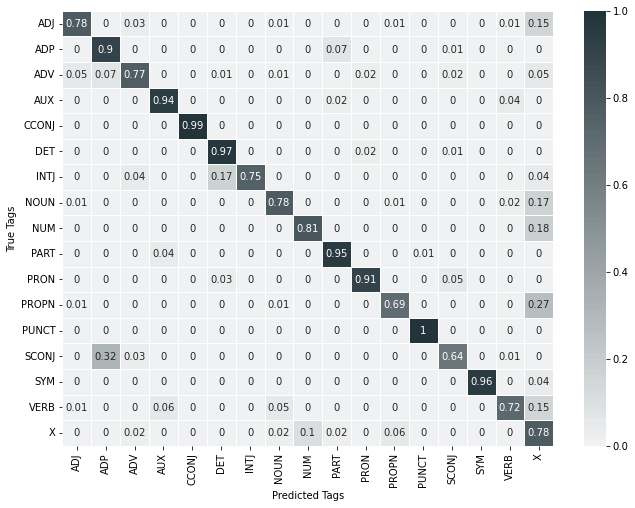

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, vocab_tags):
    
    plt.figure(figsize = (11,8))
    colors = sns.light_palette((220, 50, 20), input="husl", n_colors=80)
    ax = sns.heatmap(np.around(cm, 2),
                    annot=True,
                    linewidths=.8, 
                    cmap=colors)
    ax.set_ylim(bottom = 17, top=0)
    ax.set(xticklabels=vocab_tags)
    ax.set(yticklabels=vocab_tags)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90) 
    plt.ylabel("True Tags")
    plt.xlabel("Predicted Tags")
    plt.show()
    
plot_confusion_matrix(cm, tags_vocab)

## 3.2 <a class="anchor" id="subtask_3_2"></a>
### Study the baseline results (3 points)
By looking at the visualization of normalized confusion matrix, briefly answer the following questions in the cell below:
1. What tags were predicted best? How would you explain it? (1 point)
2. Why some tags (nouns, proper nouns, verbs...) were predicted as 'X' that often? Why 'X' was rarely mistaken with some other classes? (1 point)
3. How many unseen words were in the test corpus? Does it affect the performance of the baseline algorithm? (1 point)

**1. What tags were predicted best? How would you explain it? (1 point)**   
`ADP`, `AUX`, `CCONJ`, `DET`, `PART`, `PRON`, `PUNCT`, `SYM` were predicted best. 
In this problem, words are tagged with the tag most commonly used for the word. So being predicted correctly only means that the words do not have many different lexicals (i.e., in most cases, the words will be tagged with the same tag). A tag is predicted well, indicating that, the lexical properties of the words tagged as that tag are not as numerous and scattered.

**2. Why some tags (nouns, proper nouns, verbs...) were predicted as 'X' that often? Why 'X' was rarely mistaken with some other classes? (1 point)**     
Some words rarely appear in the text or are rarely used (e.g., proper nouns). So it is quite possible that the word is not recorded in the training text / corpus, but is encountered by chance in the test text, when it is marked as X. 

If words belonging to a tag (for example, `NOUN`) are often tagged with `X`, then it means that words belonging to `NOUN` tag(whose real tag should be `NOUN` but tagged with `X`) is not that commonly used. The higher the probability of words belonging to being `NOUN` but tagged with `X` , the higher the proportion of uncommon words in `NOUN`.

**3. How many unseen words were in the test corpus? Does it affect the performance of the baseline algorithm? (1 point)**  
unseen words count in test corpus: Count of words predicted to be X       
number of unseen word in test corpus: len(set(words predicted to be X))   
Yes. It affect baseline performance. The larger the training corpus,  the smaller the impact on the test.

## TASK 4 <a class="anchor" id="task_4"></a>
## HMM POS-tagger
An **HMM** is a probabilistic sequence model. In our case, given a sequence of words, it computes a probability distribution over possible sequences of POS tags and chooses the best tag sequence. If you find the explanations in the notebook lacking, look [here](https://web.stanford.edu/~jurafsky/slp3/A.pdf) for more information.

The *hidden part* of our HMM are tags, because they are some abstract classes that are not directly observed from text sequences. The observed part of our HMM are words these hidden tags produce (yes, we consider that POS tags emit words). 
The components of our HMM will be:
1. **T** - a set of $N$ POS tags

2. **$A$** - a transition probability matrix. Each cell $a_{i,j}$ represents the probability of moving from $tag_i$ to $tag_j$: $P(t_j|t_i)$. We also add the start and end probabilities to this matrix, so it has $N+1$ x $N+1$ dimensions. The **row** $a_1$ represents the probabilities of each tag to start a sentence. The last **column** of transition probability matrix A contains the probability of every tag ending a sentence.

<img src= "../../../coursedata/notebook_illustrations/pos-tagging/A.png">
3. **$B$** - an observation likelihood matrix. Each cell $b_{i,j}$ represents a probability of a $word_i$ being generated out of some $tag_j$: $P(w_i|t_j)$

<img src= "../../../coursedata/notebook_illustrations/pos-tagging/B.png">

Here is the corpus again, so that it is easy to check that $A$ and $B$ make sense.
<img src= "../../../coursedata/notebook_illustrations/pos-tagging/corpus.png">

### Collect probability matrices A and B

Turns out, we already have everything for our HMM! We just need to turn the counts that we collected previously into maximum likelihood probabilities.

You can do it by normalizing our word-tag and tag-tag matrices across the appropriate axis. For the tag-tag matrix, we want **the rows to sum up to 1**. For the word-tag matrix, we want **the columns to sum to one**. 

Take a second to make sure you understand why. With tag-tag matrix, we want the probability of a tag coming after some other tag. With word-tag matrix we want the probability of a tag emit some word.

Run the cell below to get the $A$ and $B$ matrices.

In [33]:
A = tt_matrix/tt_matrix.sum(axis=1)[:, np.newaxis]
B = wt_matrix/wt_matrix.sum(axis=0)

### Display the tag transition matrix A by running the cell below
Examine that everything looks as you would expect it to.

In [34]:
import pandas as pd
df = pd.DataFrame(data=A, index=["START"]+tags_vocab, columns=tags_vocab+["END"])
df

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,END
START,0.036265,0.084380,0.066840,0.014695,0.019673,0.120171,0.007111,0.083906,0.016355,0.004266,0.216639,0.110690,0.047642,0.066603,0.000000,0.098365,0.006400,0.000000
ADJ,0.061321,0.070189,0.007358,0.002264,0.038302,0.002830,0.000000,0.630755,0.007736,0.024340,0.007358,0.023585,0.096604,0.014717,0.000377,0.010566,0.000755,0.000943
ADP,0.082258,0.018618,0.012290,0.000973,0.006449,0.367121,0.000000,0.183865,0.048795,0.001339,0.103431,0.133974,0.022268,0.005111,0.000487,0.010465,0.001095,0.001460
ADV,0.147519,0.128824,0.086676,0.025833,0.021074,0.046567,0.000000,0.018015,0.030931,0.012916,0.046567,0.004079,0.181169,0.031271,0.001360,0.214140,0.000680,0.002379
AUX,0.100907,0.021171,0.133352,0.068463,0.002475,0.103107,0.000275,0.016497,0.009073,0.106406,0.041793,0.009073,0.012098,0.004399,0.000000,0.370910,0.000000,0.000000
CCONJ,0.112514,0.049369,0.082281,0.028320,0.000383,0.088021,0.000000,0.193647,0.022962,0.009185,0.107539,0.082281,0.016839,0.018752,0.001531,0.185610,0.000765,0.000000
DET,0.246703,0.000000,0.017536,0.000150,0.000000,0.000150,0.000000,0.583034,0.013339,0.000000,0.000749,0.109562,0.007644,0.000000,0.000450,0.019784,0.000899,0.000000
INTJ,0.000000,0.023810,0.000000,0.011905,0.000000,0.000000,0.083333,0.000000,0.011905,0.000000,0.083333,0.023810,0.738095,0.000000,0.000000,0.023810,0.000000,0.000000
NOUN,0.010392,0.241500,0.021060,0.068341,0.069167,0.005368,0.000000,0.099174,0.004680,0.028424,0.031659,0.010599,0.297729,0.025465,0.001445,0.071645,0.000482,0.012870
NUM,0.028589,0.108142,0.009323,0.005594,0.029211,0.004972,0.000000,0.297700,0.018024,0.004351,0.014916,0.034183,0.384711,0.004351,0.010566,0.018024,0.000000,0.027346


### HMM decoding

The aim of an HMM decoding is to choose the tag sequence $t^n_1$ that will be the most probable given the observation sequence of $n$ words $w^n_1$: $\underset{t^n_1}{\arg\max}P(t^n_1|w^n_1)$

Using Bayes' rule, we can very conveniently flip this into: $\underset{t^n_1}{\arg\max}\frac{P(w^n_1|t^n_1)P(t^n_1)}{P(w^n_1)}$. You can also notice, that we don't need the denominator for maximizing the tag sequence probability. Thus:

*best tag sequence* $= \underset{t^n_1}{\arg\max}P(w^n_1|t^n_1)P(t^n_1)$

Now we can simplify it even further by assuming:

1. the probability of a particular tag depends only on the previous tag
2. the probability of an observed word depends only on the tag that produced this word

*best tag sequence* $= \underset{t^n_1}{\arg\max}\displaystyle\prod_{i=1}^{n}P(w_i|t_i)P(t_i|t_{i-1})$

Lucky us, we've already collected probabilities $P(w_i|t_i)$ in the matrix B, and $P(t_i|t_{i-1})$ in the matrix A! Now we need to come up with how to ${\arg\max}$ those.

### Viterbi algorithm

The Viterbi algorithm is a dynamic programming algorithm for finding the most likely sequence of hidden states. In our case, its output is the most probable sequence of POS tags for some word sequence. To run this algorith we need to create two additinal tables to keep track of things (see steps 2-3).  

* STEP 1: get a sequence you want to tag:
<img src= "../../../coursedata/notebook_illustrations/pos-tagging/seq.png" width="200">
* STEP 2: create a path probability matrix $V$ with the shape (number of tags, number of words to tag). 
<img src= "../../../coursedata/notebook_illustrations/pos-tagging/table1.png" width="350">
Each cell $V_{i,j}$ keeps the probability of HMM having a tag $i$ after seeing $j$ words and passing through the most probable tag sequence $t_1,t_2...t_{i-1}$.

This most probable path of tags so far is represented as the maximum over all previous tag sequences. The probabilities of $V_{i,j}$ are computed by starting from the most probable of the extensions of the paths that lead to the current cell. It might sound very complicated now, but you will see what's going on in later steps. 

* STEP 3: create a backpointer table $P$ of shape (number of tags, number of words in a sequence).
This table is called the BACKpointer because it helps us remember where we came from. A cell $P_{i,j}$ answers a question: "If i am tagging a word $w_j$ with a tag $t_i$ now, what was the tag for the word $w_{j-1}$?". For example, if we look at the cell $P_{ADJ,hand}$ and see there 0, it means that the previous word was tagged with ADJ!

For this table we can skip the first word, since the tag before it is always the beggining of the sentence. But we need to add the imagined "END" word (tagged with dummy "END" POS tag), to use the knowledge of what tags are most likely to end a sentence.
<img src= "../../../coursedata/notebook_illustrations/pos-tagging/table2.png">

* STEP 4: start filling in the first column of $V$. Each cell $V_{i,1}$ contains a probability of a tag $i$ being the starting tag of the sentence $P(t_i|start)$ multiplied by the probability of the first word in the sequence being generated by this tag $P(word_1|t_i)$. $V_{i,1} = P(t_j|start)*P(word_1|t_j)$. According to our dummy corpus, $V_{NOUN,red} = P(NOUN|start)*P(red|NOUN)$
<img src= "../../../coursedata/notebook_illustrations/pos-tagging/table1_1.png">

* STEP 5 (probably the trickiest one): move on to filling in the second column of $V$. Each cell $V_{i,2}$ contains a product of two probabilities:
    1. the maximum from the products of every value in the previous column of $V$ and their transition probability to the tag $i$.  This value keeps the balance between what is likely according to the tag language model and what we have seen before (it can be very likely that ADJ is followed by NOUN, but it was very unlikely that the previous word is indeed ADJ). In the example below, we're trying to estimate the probability of "right" being an "ADJ" ($V_{0,2}$). We want to know: what would be the most probable path that led to the word "right" being tagged with "ADJ". Was it 'ADJ' 'red' or was it 'NOUN' 'red'? For that, we need to choose between the probabilities of 'red' being 'NOUN' and 'red' being 'ADJ' multiplied by probabilities of coming to another ADJ from those tags.
    <img src= "../../../coursedata/notebook_illustrations/pos-tagging/max.png">
    2. the probability of the second word in the sequence (word 'right') being generated by the tag $j$ $P(word_2|t_j)$
    <img src= "../../../coursedata/notebook_illustrations/pos-tagging/max_and_wt.png" width="250">
    
* STEP 6 (connected to STEP 5): save the backpointer. Write down the index of the most probable tag of the previous word! A backpointer is just $argmax$ of the values computed in 5.1. It is the index of the maximum from the products of every value in the previous column of $V$ and their transition probability to the tag $j$.  In this example, we want to remember that 'right' as 'ADJ' came from the previous word ("red") marked as 'ADJ'. So we set the backpointer  to zero $P_{0,0}=0$. This means that if the second word in a sequence was marked as "ADJ", the first word in a sequence was also "ADJ".
<img src= "../../../coursedata/notebook_illustrations/pos-tagging/backpointer.png">
* STEP 7: compute the rest of the table $V$ as in STEP 5, don't forget to save backpointers as in STEP 6.
* STEP 8: compute the final output probabilities of your tag paths by multiplying the last column of V by probability of each tag ending a sentence. We don't need to write it down.
<img src= "../../../coursedata/notebook_illustrations/pos-tagging/final.png">
* STEP 9: get last backpointer by chosing the most probable last tag from STEP 8. You can put it in all the cells of the last column.
<img src= "../../../coursedata/notebook_illustrations/pos-tagging/last_pointer.png">
* STEP 10: trace back the indices in your backpointer table P, starting with the one that was output by STEP 9. Now you can start back tracing with any cell from the last column (because, duh, they are the same). Look at the tag index that this column holds, and go to the cell with this index in the previous column of the backpointer table. In the example below, we see that the last tag had index 1 (so it was NOUN). We look at the NOUN cell in the previous time step column, and see that it was ADJ before (index zero)... and so on until the start of the sentence.
<img src= "../../../coursedata/notebook_illustrations/pos-tagging/path.png">
* STEP 11: return the most probable tag sequence. For this you just need to reverse your backtraced sequence.
<img src= "../../../coursedata/notebook_illustrations/pos-tagging/tags_predicted.png">

## 4.1 <a class="anchor" id="subtask_4_1"></a>
### Create Viterbi algorithm (5 points)

You're going to write several functions, that we then chain together. It is easier to do some parts of the algorithm in different functions for debugging purposes.
* 1 Fill in the first column of $V$.
* 2 Fill in the rest of $V$ and keep backpointers $P$.
* 3 Backtrace the most probable tag sequence from $P$.


* Note 1: to avoid numerical underflow, use log probabilities
* Note 2: log probabilities should be summed (not multiplied as the regular probabilities in our formulas)
* Note 3: when you encounter an unseen word (a word that we didn't have in the training corpus), cheat and don't include the observation probabilities (rely only on the tag probabilities) 

### 4.1.1 <a class="anchor" id="subtask_4_1_1"></a>
#### First column of V (1 point)
Look at step 4 and complete the `viterbi_first_column()` function. Note that we don't keep any backpointers for the first word, because we know that before the first word we could only have an imaginary word "START" with an imaginary tag "START".

In [35]:
def viterbi_first_column(A, B, word_sequence, tags_vocab, words_vocab):
    """
    Fills in the first column of a path probability matrix V (Step 4)
    If the first word in a sequence was not seen during training, 
    use only the pribabilities from A matrix. 
    Transform all probabilities into log with numpy.log()
    If something used to have a 0 probability, it shoud have a -inf probability in log domain now.
    
    
    Paramters
    --------
    A : a numpy array 
        transition probability matrix for POS tags
    B : a numpy array 
        an observation likelihood matrix
    word_sequence : a list of strings
        a word sequence to tag
    tags_vocab : a list of strings
        a list of UD tag labels
        in the order they're placed in matrix A
    words_vocab : a list of strings
        a list of word types seen during training 
        in the order they're placed in matrix B
        
    Returns
    -------
    path_probability_matrix - a numpy array
        a path probability matrix with first column filled in,
        other columns have zeros in them
        the shape of the matrix is len(tags_vocab) X len(word_sequence)
    """
    
    # a template for a the V matrix with -111.0 in every cell
    # NOTE: -111.0 are just placeholders here
    
    path_probability_matrix = np.full((len(tags_vocab), len(word_sequence)), -111.)
    
    # Let's change values in A and B to log
    # We're catching warnings of numpy converting zeros
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        A = np.log(A)
        B = np.log(B)
    
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    for i in range(len(path_probability_matrix)):
        tag = tags_vocab[i]
        word = word_sequence[0]
        # print(tag, word)
        
        idx_tag = tags_vocab.index(tag)
        p_t_start = A[0][idx_tag]
        
        if word in words_vocab:
            idx_word = words_vocab.index(word)
            p_w_t = B[idx_word][idx_tag]
            path_probability_matrix[i][0] = p_t_start + p_w_t 
        else:
            path_probability_matrix[i][0] = p_t_start
            
    """
    for i in range(len(path_probability_matrix)):
        if path_probability_matrix[i][0] == 0:
            ath_probability_matrix[i][0] = np.NINF
    """     
    return path_probability_matrix

In [36]:
from numpy.testing import assert_allclose
import warnings

dummy_A = np.array([[3/4,1/4,0],
                    [1/4,3/4,0],
                    [0,0,1.]])
dummy_B = np.array([[0,1],
                    [3/4,0],
                    [1/4, 0]])
dummy_test = ['red','right','hand']
dummy_tags_vocab = ["ADJ", "NOUN"]
dummy_words_vocab = ['hand','red','right']



# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check that the output is a numpy array
assert_equal(type(viterbi_first_column(dummy_A, 
                                       dummy_B, 
                                       dummy_test, 
                                       dummy_tags_vocab, 
                                       dummy_words_vocab)),np.ndarray)

# check that the output is the right shape
assert_equal(viterbi_first_column(dummy_A, 
                                   dummy_B, 
                                   dummy_test, 
                                   dummy_tags_vocab, 
                                   dummy_words_vocab).shape, (len(dummy_tags_vocab), len(dummy_test)))


# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check the function is giving out the right probabilities
assert_almost_equal(viterbi_first_column(dummy_A,
                                          dummy_B,
                                          dummy_test,
                                          dummy_tags_vocab,
                                          dummy_words_vocab)[0][0], np.log(0.562), 2)


assert_almost_equal(viterbi_first_column(dummy_A,
                                          dummy_B,
                                          dummy_test,
                                          dummy_tags_vocab,
                                          dummy_words_vocab), np.array([[-0.57536414, -111., -111.],[np.NINF, -111., -111.]]), 2)

# checking that the function is working with unknown words
dummy_test2 = ['leg','right','red']
assert_equal(viterbi_first_column(dummy_A,
                                  dummy_B, 
                                  dummy_test2, 
                                  dummy_tags_vocab,
                                  dummy_words_vocab)[0][0], np.log(dummy_A[0][0]))

assert_equal(viterbi_first_column(dummy_A,
                                  dummy_B, 
                                  dummy_test2, 
                                  dummy_tags_vocab,
                                  dummy_words_vocab)[1][0], np.log(dummy_A[0][1]))



### 4.1.2 <a class="anchor" id="subtask_4_1_2"></a>
#### The rest of V and P (3 points)
Steps 5-9

Now fill in the rest of $V$ and the whole $P$.
For the last backpointer, just fill in the whole last column of $P$ with the most probable tag for the last word. 

NOTE: if at step with max and argmax there are tags with the same probability, choose the one that comes first index-wise.

In [37]:
def viterbi_rest(path_probability_matrix, A, B, word_sequence, tags_vocab, words_vocab):
    """ Fills in V and P matrices
    
     
    Paramters
    --------
    path_probability_matrix: a numpy array
        a path probability matrix with the first column filled in
        (the result of viterbi_first_column())
    A : a numpy array 
        transition probability matrix for POS tags
    B : a numpy array 
        an observation likelihood matrix
    word_sequence : a list of strings
        a word sequence to tag
    tags_vocab : a list of strings
        a list of UD tag labels
        in the order they're placed in matrix A
    words_vocab : a list of strings
        a list of word types seen during training 
        in the order they're placed in matrix B
      
    Returns
    -------
    path_probability_matrix : a numpy array
        matrix V
    backpointer_table : a numpy array
        a matrix P with backpointers
    """
    # a template for a backpointer table with -111 in every cell as placeholders
    backpointer_table = np.full((len(tags_vocab), len(word_sequence)), -111)
    
    # Let's change values in A and B to log
    # We're catching warnings of numpy converting zeros

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        A = np.log(A)
        B = np.log(B)

    
    # FILL IN THE REST OF THE path_probability_matrix
    # DON'T FORGET TO KEEP BACKPOINTERS            
    # YOUR CODE HERE
    # raise NotImplementedError()
    dict_temp = dict(zip(tags_vocab, [0]*len(tags_vocab)))# record P(t|key)
    
    for i in range(len(word_sequence)-1): # dealing with col i+1
        word = word_sequence[i+1]
        word_idx_flag = True
        if word in words_vocab:
            word_idx = words_vocab.index(word)
        else:
            word_idx_flag = False
            
        # print("dealing with",i+1,"col，for word:", word)
         
        for tag_i1_idx in range(len(tags_vocab)): # dealing with col i+1 and tag_id tag_i1_idx
            # print("assume i+1th word's tag:", tags_vocab[tag_i1_idx])
            temp_tag_ls = []
            
            for tag_i_idx in range(len(tags_vocab)):
                p_tag_tran = A[tag_i_idx+1][tag_i1_idx]
                # print(tags_vocab[tag_i1_idx], tags_vocab[tag_i_idx], p_tag_tran)
                
                previous_p = path_probability_matrix[tag_i_idx][i]
                # print("【value of previous column】previous_p:", previous_p, "or", np.e ** previous_p)
                # print("【tag trans p】 p_tag_tran:tag p(", tags_vocab[tag_i1_idx], "|",tags_vocab[tag_i_idx], ")",p_tag_tran,  "or", np.e ** p_tag_tran)
                temp_tag_ls.append(previous_p + p_tag_tran)
                # print("temp_tag_ls:", temp_tag_ls)
    
            argmax_ti_idx = temp_tag_ls.index(max(temp_tag_ls)) # argmax_ti_idx -> tag_i1_idx
            # print("【find max value】argmax_ti_idx：", tags_vocab[tag_i1_idx], tags_vocab[argmax_ti_idx], "->", tags_vocab[tag_i1_idx])
            
            backpointer_table[tag_i1_idx][i] = argmax_ti_idx
            
            # print("【update backpointer_table】", backpointer_table)
            
            path_probability_matrix[tag_i1_idx][i+1] = max(temp_tag_ls)
            if word_idx_flag == True:
                p_w_t = B[word_idx][tag_i1_idx]
                # print("p_w_t:P(", words_vocab[word_idx], "|", tags_vocab[tag_i1_idx], ")=", p_w_t,  "or", np.e ** p_w_t)
                path_probability_matrix[tag_i1_idx][i+1] = p_w_t + path_probability_matrix[tag_i1_idx][i+1]
            
            # print("【update path_probability_matrix】", path_probability_matrix)
    

    ls_last_col_path_proba = list(path_probability_matrix.T[len(word_sequence)-1])
    # print("ls_last_col_path_proba", ls_last_col_path_proba)
    ls_last_tag_trans = list(A.T[len(tags_vocab)])[1:]
    # print("ls_last_tag_trans", ls_last_tag_trans)
    p = [ls_last_col_path_proba[i] + ls_last_tag_trans[i] for i in range(len(ls_last_tag_trans))]

    last_idx = p.index(max(p))
    
    for i in range(len(backpointer_table)):
        backpointer_table[i][backpointer_table.shape[1]-1] = last_idx
    
    return path_probability_matrix, backpointer_table

In [38]:
dummy_A = np.array([[3/4,1/4,0],
                    [1/4,3/4,0],
                    [0,0,1.]])

dummy_B = np.array([[0,1],
                    [3/4,0],
                    [1/4, 0]])

dummy_test = ['red','right','hand']
dummy_tags_vocab = ["ADJ", "NOUN"]
dummy_words_vocab = ['hand','red','right']
dummy_V = np.array([[-0.57536414,0.,0.],
                    [np.NINF,0.,0.]])

correct_P = np.array([[0, 0, 1],
                      [0, 0, 1]])



# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check that the output is a numpy array
assert_equal(type(viterbi_rest(dummy_V,
                               dummy_A, 
                               dummy_B, 
                               dummy_test, 
                               dummy_tags_vocab, 
                               dummy_words_vocab)[0]),np.ndarray)

assert_equal(type(viterbi_rest(dummy_V,
                               dummy_A, 
                               dummy_B, 
                               dummy_test, 
                               dummy_tags_vocab, 
                               dummy_words_vocab)[1]),np.ndarray)

assert_equal(viterbi_rest(dummy_V,
                          dummy_A, 
                          dummy_B,
                          dummy_test,
                          dummy_tags_vocab,
                          dummy_words_vocab)[0].shape, (len(dummy_tags_vocab), len(dummy_test)))
             
assert_equal(viterbi_rest(dummy_V,
                          dummy_A, 
                          dummy_B, 
                          dummy_test, 
                          dummy_tags_vocab, 
                          dummy_words_vocab)[1].shape, (len(dummy_tags_vocab), len(dummy_test)))



# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check the function is giving out the right probabilities
assert_almost_equal(viterbi_rest(dummy_V,
                                 dummy_A,
                                 dummy_B,
                                 dummy_test,
                                 dummy_tags_vocab,
                                 dummy_words_vocab)[0][0][1], np.log(0.035), 2)

# check the function is giving out the right backpointers
assert_array_equal(viterbi_rest(dummy_V,
                                 dummy_A,
                                 dummy_B,
                                 dummy_test,
                                 dummy_tags_vocab,
                                 dummy_words_vocab)[1], correct_P)

# checking that the function is working correctly with unknown words
dummy_test2 = ['red','right','leg']
dummy_V2 = np.array([[-0.28768207,  -111., -111.],
                     [-1.38629436,  -111., -111.]])

correct_V2 = np.array([[-0.28768207, -3.06027079, -4.44656515],
                       [-1.38629436,        np.NINF, -3.34795286]])

correct_P2 = np.array([[0, 0, 1],
                       [0, 0, 1]])

assert_almost_equal(viterbi_rest(dummy_V2,
                                  dummy_A,
                                  dummy_B, 
                                  dummy_test2, 
                                  dummy_tags_vocab,
                                  dummy_words_vocab)[0], correct_V2, 3)

assert_array_equal(viterbi_rest(dummy_V2,
                                  dummy_A,
                                  dummy_B, 
                                  dummy_test2, 
                                  dummy_tags_vocab,
                                  dummy_words_vocab)[1], correct_P2)


# checking that the function is working as intended with equal probabilities
dummy_A_eq = np.array([[1/2,1/2,0],
                       [1/2,0,1/2],
                       [0,1/2,1/2]])

dummy_B_eq = np.array([[1/2,1/2],
                       [1/2,1/2]])

dummy_test_eq = ["W1", "W2"]
dummy_tags_vocab_eq = ["T1", "T2"]
dummy_words_vocab_eq = ['W1','W2']

dummy_V_eq = np.array([[-1.38629436, -111.],
                       [-1.38629436, -111.]])

correct_P_eq = [[0, 0],
                [1, 0]]

correct_V_eq = np.array([[-1.38629436, -2.77258872],
                         [-1.38629436, -2.77258872]])

assert_almost_equal(viterbi_rest(dummy_V_eq,
                                 dummy_A_eq,
                                 dummy_B_eq,
                                 dummy_test_eq, 
                                 dummy_tags_vocab_eq,
                                 dummy_words_vocab_eq)[0], correct_V_eq, 3)

assert_array_equal(viterbi_rest(dummy_V_eq,
                                 dummy_A_eq,
                                 dummy_B_eq,
                                 dummy_test_eq, 
                                 dummy_tags_vocab_eq,
                                 dummy_words_vocab_eq)[1], correct_P_eq)

### 4.1.3 <a class="anchor" id="subtask_4_2_3"></a>
#### Traceback the Tag sequence (1 point)
Steps 10-11

Take the backpointer matrix and trace the most probable tag sequence.

In [39]:
def trace_backpointers(backpointer_table, tags_vocab):
    """ Traces tag sequence from a backpointer table P
    
    Parameters
    ----------
    backpointer_table : a numpy array
        a matrix P with backpointers
    tags_vocab : a list of strings
        a list of UD tag labels
        
    Returns
    -------
    best_path : a list of strings
        most probable tags for the words in a test sequence
    """
    
    
    best_path = []
    # YOUR CODE HERE
    # raise NotImplementedError()
    word_length = backpointer_table.shape[1]
    
    idx = backpointer_table[0][word_length-1]
    best_path.append(tags_vocab[idx])
    
    for i in range(word_length-2,-1,-1):
        idx = backpointer_table[idx][i]
        best_path.append(tags_vocab[idx])
        
    return best_path[::-1]

In [40]:
dummy_A = np.array([[3/4,1/4,0],
                    [1/4,3/4,0],
                    [0,0,1.]])

dummy_B = np.array([[0,1],
                    [3/4,0],
                    [1/4, 0]])

dummy_test = ['red','right','hand']
dummy_tags_vocab = ["ADJ", "NOUN"]
dummy_words_vocab = ['hand','red','right']

correct_dummy_tags = ['ADJ', 'ADJ', 'NOUN']
correct_P = np.array([[0, 0, 1],
                      [0, 0, 1]])

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check that we get a list of strings
assert_equal(type(trace_backpointers(correct_P, dummy_tags_vocab)), list)
assert_equal(type(trace_backpointers(correct_P, dummy_tags_vocab)[0]), str)
# check the length
assert_equal(len(trace_backpointers(correct_P, dummy_tags_vocab)), correct_P.shape[1])

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
assert_equal(trace_backpointers(correct_P, dummy_tags_vocab), correct_dummy_tags)

P2 = np.array([[1, 0, 1],
               [0, 2, 1],
               [1, 1, 1]])

assert_equal(trace_backpointers(P2, ["T1", "T2","T3"]), ["T2","T3","T2"])



### Evaluate HMM
Run the cell below to get an accuracy score for your HMM tagger and to plot the confusion matrix. Your accuracy should be better than baseline. Note that the computations take some time.

0.9019055424649114


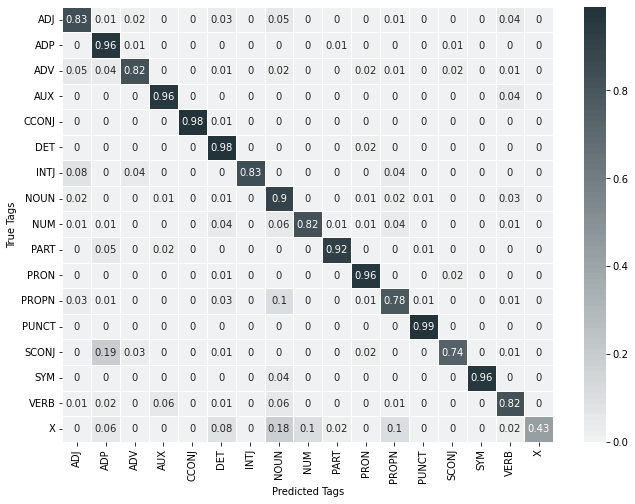

In [41]:
hmm_tags_predicted = []
for i in range(len(test_words)):
    V = viterbi_first_column(A, B, test_words[i], tags_vocab, words_vocab)
    _, P = viterbi_rest(V, A, B, test_words[i], tags_vocab, words_vocab)
    hmm_tags_predicted.append(trace_backpointers(P, tags_vocab))

print(accuracy_score([tag for sentence in test_tags for tag in sentence],
                     [tag for sentence in hmm_tags_predicted for tag in sentence]))

cm_hmm = create_confusion_matrix(test_tags, hmm_tags_predicted)
plot_confusion_matrix(cm_hmm, tags_vocab)

## 4.2  <a class="anchor" id="subtask_4_2"></a>
### Compare HMM and Baseline (1 point)

In the cell below, briefly decribe the differences in the performance of our HMM and the baseline model (0.5 points). What can be done to further improve the HMM model (0.5 points)?

**differences in the performance of our HMM and the baseline model**：     
- baseline model only rely on character of the word itself (e.g., frequency of tags of word). And the connection information between words and words (or tag and tag) is ignored.    
- In HMM model, the sequence labeling problem is not only related to a single word, but also related to the conversion between tags.   



**What can be done to further improve the HMM model**:     

- HMM does not extract much contextual semantic information: When tagging with HMM, it only relies on the information of the previous single word to estimate the current word. The improvement method can be: replace the `A· matrix with $P(tag_{i}| tag_{i-1},tag_{i-2})$ and so on.

- The `A`, `B` matrix used by HMM is often defined only based on the training corpus and cannot be customized or learned. The improvement can be: let the matrix be defined based on some feature functions based on experience (for example, feature functions in CRF). 

## Checklist before submission <a class="anchor" id="checklist"></a>
### 1
To make sure that you didn't forget to import some package or to name some variable, press **Kernel -> Restart** and then **Cell -> Run All**. This way your code will be run exactly in the same order as during the autograding.
### 2
Click the **Validate** button in the upper menu to check that you haven't missed anything. Be careful now (Viterbi takes time, you might need to validate through the terminal).
### 3
To submit the notebook, click on the **jupyterhub** logo in the upper left part of the window, choose the **Assignments** folder, and press **submit**. You can submit multiple times, only the last one counts.
### 4
Please fill in the feedback form in the [Assignment](https://mycourses.aalto.fi/mod/questionnaire/view.php?id=984935) section of Mycoures.